In [118]:
!pip install ipython-autotime
%load_ext autotime
import pandas as pd
from google.colab import drive
import pathlib
import numpy as np
import gc
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import pyarrow.parquet as pq
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


drive.mount('/content/drive',force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Mounted at /content/drive
time: 8.41 s (started: 2022-11-23 04:44:09 +00:00)


In [92]:
random_state=17

time: 691 µs (started: 2022-11-23 03:13:14 +00:00)


In [93]:
taxiData = pd.DataFrame()

time: 1.47 ms (started: 2022-11-23 03:13:14 +00:00)


In [94]:
data_dir = "/content/drive/MyDrive/yellow_tripdata_2020_data.parquet"
data_dir = pathlib.Path(data_dir)
yellowTaxiData2020 = pq.ParquetFile(data_dir)
del data_dir

time: 68.5 ms (started: 2022-11-23 03:13:14 +00:00)


In [95]:
for taxiDataBatch in yellowTaxiData2020.iter_batches(batch_size=2000000):
    taxiDataBatchDF = taxiDataBatch.to_pandas()
    taxiDataBatchDF.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time'], inplace=True)
    taxiData = pd.concat([taxiData, taxiDataBatchDF])

time: 7.02 s (started: 2022-11-23 03:13:17 +00:00)


In [96]:
taxiData.shape

(4069192, 18)

time: 31.2 ms (started: 2022-11-23 03:13:25 +00:00)


In [97]:
del yellowTaxiData2020

time: 704 µs (started: 2022-11-23 03:13:28 +00:00)


In [98]:
gc.collect()

172

time: 739 ms (started: 2022-11-23 03:13:30 +00:00)


In [99]:
data_dir = "/content/drive/MyDrive/yellow_tripdata_2021_data.parquet"
data_dir = pathlib.Path(data_dir)
yellowTaxiData2021 = pq.ParquetFile(data_dir)
del data_dir

time: 8.96 ms (started: 2022-11-23 03:13:31 +00:00)


In [100]:
gc.collect()

88

time: 199 ms (started: 2022-11-23 03:13:34 +00:00)


In [101]:
for taxiDataBatch in yellowTaxiData2021.iter_batches(batch_size=2000000):
    taxiDataBatchDF = taxiDataBatch.to_pandas()
    taxiDataBatchDF.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_date', 'pickup_time', 'dropoff_date', 'dropoff_time'], inplace=True)
    taxiData = pd.concat([taxiData, taxiDataBatchDF])

time: 30.4 s (started: 2022-11-23 03:13:37 +00:00)


In [102]:
scaler = MinMaxScaler()
taxiData = pd.DataFrame(scaler.fit_transform(taxiData.values), columns=taxiData.columns, index=taxiData.index)

time: 17.3 s (started: 2022-11-23 03:14:13 +00:00)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(taxiData.loc[:, (taxiData.columns!='ride_duration')], 
                                                    taxiData.loc[:, 'ride_duration'], 
                                                    test_size=0.2, 
                                                    random_state=random_state)

time: 21.3 s (started: 2022-11-23 03:14:56 +00:00)


In [105]:
X_train, X_val, y_train, y_val = train_test_split(taxiData.loc[:, (taxiData.columns!='ride_duration')], 
                                                    taxiData.loc[:, 'ride_duration'], 
                                                    test_size=0.2, 
                                                    random_state=random_state)

time: 23.8 s (started: 2022-11-23 03:15:17 +00:00)


In [106]:
del yellowTaxiData2021
del taxiData
gc.collect()

153

time: 95.9 ms (started: 2022-11-23 03:16:02 +00:00)


In [107]:
lgbmRegressor = lgb.LGBMRegressor()

time: 875 µs (started: 2022-11-23 03:16:07 +00:00)


In [108]:
lgbmParamsForRandomCV = {'n_estimators': [5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 15, 20, 25, 30, 35, 40], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

randomSearchCV = RandomizedSearchCV(estimator = lgbmRegressor, param_distributions = lgbmParamsForRandomCV, n_iter = 10, verbose=2, random_state=random_state, n_jobs = -1)
randomSearchCV.fit(X_train[:5000000], y_train[:5000000])
print(randomSearchCV.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
LGBMRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=2,
              min_samples_split=5, n_estimators=10)
time: 4min 7s (started: 2022-11-23 03:16:09 +00:00)


In [109]:
lgbmRegressor = lgb.LGBMRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=2,
              min_samples_split=5, n_estimators=10, objective='regression', feature_fraction=0.9, bagging_fraction=0.5, max_bin=1000, learning_rate=0.1, random_state=random_state)


time: 1.1 ms (started: 2022-11-23 03:20:27 +00:00)


In [110]:
lgbmRegressor.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='l1',callbacks=[lgb.early_stopping(20)])

[1]	valid_0's l1: 0.163832	valid_0's l2: 0.040337
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.153269	valid_0's l2: 0.035597
[3]	valid_0's l1: 0.144177	valid_0's l2: 0.031751
[4]	valid_0's l1: 0.136353	valid_0's l2: 0.0286089
[5]	valid_0's l1: 0.129572	valid_0's l2: 0.026024
[6]	valid_0's l1: 0.123772	valid_0's l2: 0.0239192
[7]	valid_0's l1: 0.11879	valid_0's l2: 0.0221901
[8]	valid_0's l1: 0.114496	valid_0's l2: 0.020764
[9]	valid_0's l1: 0.11382	valid_0's l2: 0.0205308
[10]	valid_0's l1: 0.113275	valid_0's l2: 0.0203421
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 0.113275	valid_0's l2: 0.0203421


LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.9, max_bin=1000,
              max_depth=40, max_features='sqrt', min_samples_leaf=2,
              min_samples_split=5, n_estimators=10, objective='regression',
              random_state=17)

time: 37.1 s (started: 2022-11-23 03:20:43 +00:00)


In [116]:
predictions_train = lgbmRegressor.predict(X_train, num_iteration=lgbmRegressor.best_iteration_)

time: 18.5 s (started: 2022-11-23 04:02:04 +00:00)


In [111]:
predictions = lgbmRegressor.predict(X_test, num_iteration=lgbmRegressor.best_iteration_)

time: 2.28 s (started: 2022-11-23 03:21:58 +00:00)


In [117]:
rmse_train = mean_squared_error(y_train, predictions_train)**0.5
print(f'The RMSE of training prediction is: {rmse_train}')

The RMSE of training prediction is: 0.14264482481396076
time: 282 ms (started: 2022-11-23 04:02:55 +00:00)


In [120]:
mse_train = mean_squared_error(y_train, predictions_train)
print(f'The MSE of training prediction is: {mse_train}')

The MSE of training prediction is: 0.020347546046205554
time: 139 ms (started: 2022-11-23 04:46:19 +00:00)


In [121]:
mae_train = mean_absolute_error(y_train, predictions_train)
print(f'The MAE of training prediction is: {mae_train}')

The MAE of training prediction is: 0.11329334110638502
time: 394 ms (started: 2022-11-23 04:46:29 +00:00)


In [112]:
rmse_test = mean_squared_error(y_test, predictions)**0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 0.14262587545327904
time: 40.5 ms (started: 2022-11-23 03:22:05 +00:00)


In [122]:
mse_test = mean_squared_error(y_test, predictions)
print(f'The MSE of prediction is: {mse_test}')

The MSE of prediction is: 0.02034214034881426
time: 143 ms (started: 2022-11-23 04:46:37 +00:00)


In [123]:
mae_test = mean_absolute_error(y_test, predictions)
print(f'The MAE of training prediction is: {mae_test}')

The MAE of training prediction is: 0.11327522834307302
time: 61.1 ms (started: 2022-11-23 04:46:48 +00:00)


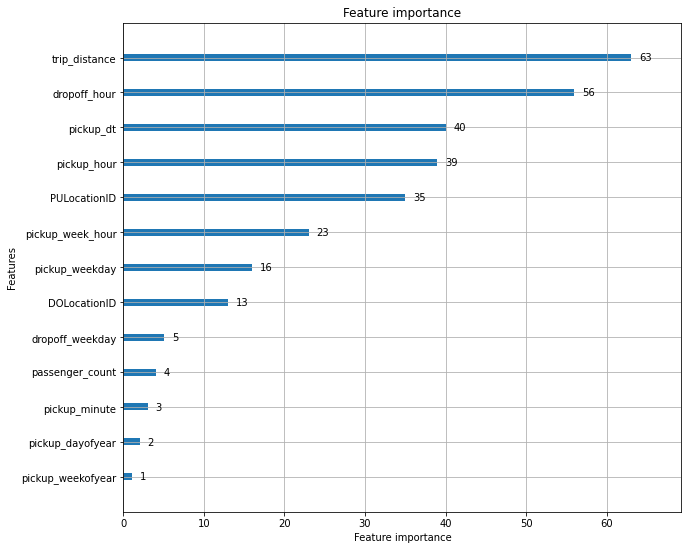

time: 322 ms (started: 2022-11-23 03:22:09 +00:00)


In [113]:
lgb.plot_importance(lgbmRegressor, figsize=(10, 9))